In [1]:
# default_exp optim_w_augment
%load_ext autoreload
%autoreload 2

# Optimising With Augmentation

> Optimisation the whole alphabet using the augmented OCR model and with augmented renderings for `OCRLoss`.

In [2]:
#export
from aifont.core import *
from aifont.fontlearner import *
from aifont.ocrlearner import *
from collections import OrderedDict
from enum import Enum, auto
from fastai.data.all import *
from fastai.vision.all import *
import gc
from nbdev.showdoc import *
from pandas import DataFrame
import pydiffvg
import torch
from typing import Callable, List, Protocol, Tuple, Union

## Font Learner Factory

In [3]:
#export

def get_learner(seed = 42, 
    version = "aug", 
    use_ocr_tfms = False,
    tfms_p = .5,
    tfms_set = "default",
    **kwargs
    ) -> VectorLearner:
    gc.collect()
    if 'ocr_model' not in locals() or ocr_model is None:
        ocr_model = load_ocr_model(arch=kaggle_cnn_a_with_res, 
                                   df=get_combined_az_and_tmnist_df,
                                   version=version)
    cb = DebugCB(vocal=False)
    ocr_tfms = None
    if use_ocr_tfms:
        # These are the same ones as used for the OCR model
        max_rotate = 15.0
        max_warp = .25
        size = 28
        if   tfms_set == "strong":  blur = GaussianBlur(p=tfms_p, random_size=(5, 9), sigma=10.)
        elif tfms_set == "xstrong": blur = GaussianBlur(p=tfms_p, kernel_size=(9, 9), sigma=10.)
        else:                       blur = GaussianBlur(p=tfms_p, random_size=5)
        noise = Noise(p=tfms_p, f=(0., .6))
        tfms = aug_transforms(mult=1.0, do_flip=False, flip_vert=False, max_rotate=max_rotate, 
                              min_zoom=0.85, max_zoom=1.15, max_warp=max_warp, p_affine=tfms_p, 
                              p_lighting=0., xtra_tfms=None, size=size, mode='bilinear', 
                              pad_mode='reflection', align_corners=True, batch=False, 
                              min_scale=1.0)
        warp = tfms[0]
        ocr_tfms = [warp, blur]
        if tfms_set == "default": ocr_tfms += noise
    learner = create_font_learner(ocr_tfms=ocr_tfms,
                                letters=None,
                                cbs=cb,
                                folder=None,
                                ocr_model=ocr_model,
                                n_colors_out=1,
                                lr=1e-2, 
                                init_range=2.,
                                seed=seed,
                                **kwargs)
    if use_ocr_tfms: assert len(learner.loss_func.ocr_loss.tfms) == len(ocr_tfms)
    return learner

## Optimisation Utilities

Copied from `05_full_aphabet_optimisation.ipynb`. 

In [4]:
DUMP_FOLDER = "results/test_10_augmented"

class ParamRecorderCB(Callback):
    best: dict = None
    best_on = None
    last_best_loss = None
    results: list[dict] = []
    def __init__(self, 
        max_epochs_after_best: int = None, 
        *args, **kwargs
        ):
        super(ParamRecorderCB, self).__init__(*args, **kwargs)
        store_attr("max_epochs_after_best")
    def before_fit(self):
        self.best_on = 0
        if self.best is None: self.last_best_loss = self.get_current_loss()
    def after_loss(self):
        if not self.training: return
        l  = self.loss.item()
        lr = self.opt.hypers[-1]["lr"]
        p  = self.get_param_dict()
        if not self.best or l < self.best["loss"]:
            self.best = dict(loss=l, lr=l, params=p)
            self.best_on = self.epoch
        elif self.max_epochs_after_best is not None and \
             self.epoch - self.best_on > self.max_epochs_after_best:
            raise CancelFitException()
    def after_fit(self):
        impr = self.last_best_loss - self.best["loss"]
        self.last_best_loss = self.best["loss"]
        impr_fr = impr / (self.last_best_loss + EPS)
        self.results.append(dict(impr=impr, 
                                 impr_fr=impr_fr,
                                 stopped_at=self.epoch,
                                 n_epochs=self.n_epoch,
                                 **self.best))
        print(f"Improvement {impr:.4f} ({impr_fr:.2%})")
    def reset_to_best(self):
        """Reset to the best saved parameters."""
        assert self.best
        self.load_param_dict(self.best["params"])

def fancy_fit_2(
    learner: VectorLearner,
    param_cb: ParamRecorderCB,
    epochs = 100,
    epoch_increment = 0,
    lr = 1e-1,
    lr_factor = .9,
    iters = 40,
    max_zero_iters = 2,
    max_epochs_after_best = 10
    ) -> list[dict]:
    """A fancier fitting algorithm, which tests picks the best epoch after
       fitting, resets to that and adjusts `lr` and `epochs` if needed."""
    old_max = param_cb.max_epochs_after_best
    param_cb.max_epochs_after_best = max_epochs_after_best
    last_zero = None
    for i in range(iters):
        clear()
        print(f"Iteration {i + 1}/{iters} • lr {lr:.4f}")
        learner.fit(epochs, lr)
        res = param_cb.results[-1]
        if res["impr"] <= 0 or res["stopped_at"] < res["n_epochs"] - 1:
            param_cb.reset_to_best()
            if last_zero is None: last_zero = i
            if max_zero_iters is not None and i - last_zero > max_zero_iters: break
            lr        *= lr_factor
            epochs    += epoch_increment
        else: last_zero = None
    clear()
    param_cb.max_epochs_after_best = old_max
    return param_cb.results

def fancy_fit_2_variations(
    filename: str,
    variations = 50,
    dump_folder = DUMP_FOLDER,
    bs = None,
    ocr_version = "aug", 
    use_ocr_tfms = False,
    tfms_p = .5,
    tfms_set = "default",
    **kwargs
    ) -> list[dict]:
    """Create `iters` optimised iterations by reinitialising parameters either randomly
        or from `initial_params` list and training for `epochs` with `lrs`."""
    def noop(*args): pass
    path = os.path.join(dump_folder, filename)
    results = []
    for k in range(variations):
        gc.collect()
        self = get_learner(seed=None, bs=bs, version=ocr_version, use_ocr_tfms=use_ocr_tfms, tfms_p=tfms_p, tfms_set=tfms_set)
        param_cb = ParamRecorderCB()
        self.add_cb(param_cb)
        self.recorder.logger = noop
        self.reset_parameters()
        init_pars = self.get_param_dict()
        init_loss = self.get_current_loss()
        var_res = fancy_fit_2(self, param_cb, **kwargs)
        res = {
            "initial_params": init_pars,
            "final_params":   self.get_param_dict(),
            "init_loss":      init_loss,
            "final_loss":     var_res[-1]["loss"],
            "full_res":       var_res,
            "img":            self.render_letters()
            }
        dump(res, f"{path}{k}.pkl")
        results.append(res)
    dump(results, f"{path}all.pkl")
    return results

def plot_variation_results(
    variations: list[dict],
    figsize = (6, 6),
    lim: float = None
    ) -> None:
    """Plot the results from `fancy_fit_2_variations`."""
    df = DataFrame(variations)
    if lim is None: lim = math.ceil(max(df.init_loss)) 
    init_med, final_med = np.median(df.init_loss), np.median(df.final_loss)
    impr_med = np.median((df.init_loss - df.final_loss) / df.init_loss)
    min_loss = df.final_loss.min()
    fig = plt.figure(figsize=figsize)
    ax  = plt.gca()
    ax.set_xlim(0, lim), ax.set_ylim(0, lim)
    ax.scatter(df.init_loss, df.final_loss)
    ax.scatter(init_med, final_med)
    plt.suptitle(f"Initial losses vs final losses\n(median in orange, median improvement {impr_med:.2%},\nmin loss {min_loss:.4f})")
    plt.xlabel(f"Initial loss"), plt.ylabel(f"Final loss")

def show_variation_renders(
    variations: Union[list[dict], DataFrame],
    n = 12,
    n_cols = 4,
    fig_width = 14,
    incl_tfms = False,
    learner: VectorLearner = None
    ) -> plt.Figure:
    """Show the rendered images together with losses, possibly paired with loss-function-transformed images."""
    if incl_tfms: assert learner is not None, "You must supply a learner if incl_tfms is True"
    if type(variations) is list: variations = DataFrame(variations)
    variations = variations.sort_values(by="final_loss").reset_index()
    n_imgs = n if n is not None and len(variations) > n else len(variations)
    if incl_tfms: n_imgs *= 2
    n_rows = math.ceil(n_imgs / n_cols)
    _img = variations.iloc[0].img
    img_ratio = _img.height / _img.width
    fig_height = (fig_width / n_cols * img_ratio + .5) * n_rows
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(fig_width, fig_height))
    axs = axs.flatten()
    for i, ax in enumerate(axs):
        if i >= n_imgs: break
        is_tfmd = incl_tfms and i % 2 == 1
        v = variations.iloc[i//2 if incl_tfms else i]
        if is_tfmd: img = v.img_with_tfms if "img_with_tfms" in v else \
                          learner.load_param_dict(v.final_params).render_letters(apply_tfms=True)
        else:       img = v.img
        ax.imshow(img)
        ax.set_title("With loss tfms" if is_tfmd else f"Loss {v.final_loss:.4f}")
    title = "Rendered fonts and losses"
    if incl_tfms: title += "\nwith examples of loss-function-transformed images\n(Note that true transforms may be randomised)"
    fig.suptitle(title)
    plt.show()
    return fig

def avg_loss(
    learner,
    n = 20,
    return_list = False
    ) -> float:
    """Calc avg loss over `n` iterations."""
    losses = []
    for i in range(n): losses.append(learner.get_current_loss())
    return losses if return_list else sum(losses) / n

def print_losses(
    losses: Union[list, np.array], 
    msg = None
    ) -> dict:
    """Print basic stats of losses."""
    if msg is not None: msg += ": "
    losses = np.array(losses)
    l_mean = losses.mean()
    l_std = losses.std()
    l_spread = losses.max() - losses.min()
    print(f"{msg}Mean: {l_mean:.4f} • SD: {l_std:.4f} ({l_std / l_mean:.1%}) • Spread {l_spread:.4f} ({l_spread / l_mean:.1%})")
    return(dict(mean=l_mean, std=l_std, spread=l_spread))

def get_individual_losses(
    learner,
    iters = 20
    ) -> np.array:
    """Get losses for individual letters. Mean over `iters`."""
    loss = OCRLoss(ocr_model=load_ocr_model(arch=kaggle_cnn_a_with_res, df=get_combined_az_and_tmnist_df),
                   tfms=learner.loss_func.ocr_loss.tfms, reduction='none')
    b = L(learner.dls.train)[0]
    x, y = b
    losses = {k.item(): [] for k in y}
    for i in range(iters):
        v = learner.model(x)
        ll = loss(v, y)
        for k, l in zip(y, ll[0]): losses[k.item()].append(l.item())
    losses_list = [losses[k] if k in losses else [-1.] for k in range(len(learner.vocab))]
    means = [np.array(l).mean() for l in losses_list]
    return np.array(means)

def plot_current_individual_losses(
    learner,
    **kwargs
    ) -> np.array:
    means = get_individual_losses(learner, **kwargs)
    letters = learner.vocab
    fig = plt.figure()
    ax = fig.add_subplot()
    line, = ax.plot(means)
    ax.set_xticks(range(len(letters)), labels=letters)
    return means

def try_params(
    learner,
    param = "Width, HNU",
    steps = 40,
    min = -4., max = 4., 
    loss_iters = 20
    ) -> DataFrame:
    """Try different param values and record individual letters losses (mean overs `loss_iters`)."""
    assert steps > 1
    self = learner
    lf = self.loss_func
    with debug(lf):
        model = self.model
        stats = []
        for i in range(steps):
            report("Trying params", prog = i / steps)
            v = min + (max - min) * i / (steps - 1)
            model.set_param(param, v)
            means = {f"loss_{k}": v for k, v in zip(learner.vocab, get_individual_losses(learner, iters=loss_iters))}
            d = {
                "value": model.get_param(param).item(), # There's a discrepancy between v and this
                "interpolated_value": model.get_param_value(param).item(),
                **means
                }
            stats.append(d)
    return DataFrame(stats)

def create_or_load_variations(fn: str,
    plot = True,
    **fancy_fit_args
    ) -> list[dict]:
    """Shortcut for `fancy_fit_2_variations` that saves the results. If there 
       already are results saved with `fn`, loads them instead."""
    fp = os.path.join(DUMP_FOLDER, fn)
    try: res = load(fp)
    except: 
        res = fancy_fit_2_variations(**fancy_fit_args, filename=fn)
        dump(res, fp)
    if plot: plot_variation_results(res, lim=4)
    return res

def apply_best_params(learner,
    variations: list
    ) -> VectorLearner:
    "Apply the params with the lowest loss from variations to learner."
    best = sorted(variations, key=lambda x: x["final_loss"])[0]
    learner.load_param_dict(best["final_params"])
    return learner

def fancy_fit_3_variations(
    filename: str,
    variations = 50,
    dump_folder = DUMP_FOLDER,
    bs = None,
    version = "aug", 
    use_ocr_tfms = False,
    tfms_p = .5,
    tfms_set = "default",
    zero_width = False,
    **kwargs
    ) -> list[dict]:
    """Create `iters` optimised iterations by reinitialising parameters either randomly
        or from `initial_params` list and training for `epochs` with `lrs`."""
    path = os.path.join(dump_folder, filename)
    results = []
    for k in range(variations):
        gc.collect()
        self = get_learner(seed=None, bs=bs, version=version, use_ocr_tfms=use_ocr_tfms, tfms_p=tfms_p, tfms_set=tfms_set)
        self.reset_parameters()
        if zero_width:
            for p in self.param_names:
                if p.startswith("Width"): self.set_param(p, 0.)
        init_pars = self.get_param_dict()
        init_loss = self.get_current_loss()
        with self.no_progress(): var_res = fancy_fit_3(self, msg=f"Variation {k + 1}/{variations} • ", **kwargs)
        res = {
            "initial_params": init_pars,
            "final_params":   var_res[-1]["params"],
            "init_loss":      init_loss,
            "final_loss":     var_res[-1]["loss"],
            "full_res":       var_res,
            "img":            self.render_letters(),
            "img_with_tfms":  self.render_letters(apply_tfms=True)
            }
        dump(res, f"{path}{k}.pkl")
        results.append(res)
    dump(results, f"{path}all.pkl")
    return results

def fancy_fit_3(learner: VectorLearner,
    epochs = 40,
    epoch_increment = 0,
    lr = 1e-1,
    lr_factor = .9,
    iters = 20,
    abort_if = 0.75,
    abort_at = 2,
    msg = ""
    ) -> list[dict]:
    """Perform multiple fitting sessions."""
    res = []
    orig_loss = learner.get_current_loss()
    for i in range(iters):
        report(f"{msg}Iteration {i + 1}/{iters} • lr {lr:.4f}")
        learner.fit(epochs, lr)
        l = learner.get_current_loss()
        res.append(dict(lr=lr,
                        loss=l,
                        params=learner.get_param_dict() ))
        if i >= abort_at and l > abort_if * orig_loss: break
        lr *= lr_factor
        epochs += epoch_increment
    clear()
    return res

## 1. Optimise Using Augmented OCR

Recreate the same optimisation procedure from notebook 05 with the augmented OCR model.

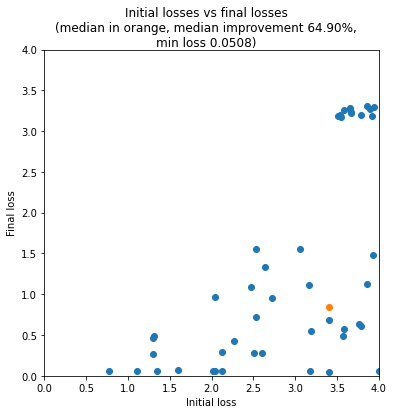

In [5]:
fn_exp1  = "variations_exp1_aug_ocr"
res_exp1 = create_or_load_variations(fn_exp1,
                                     lr = 1e-1,
                                     lr_factor = .9,
                                     iters = 40, # bs = len(VOCAB_UC) * 4
                                     )

Prima facie, the results look different from the non-augmented ones. The loss values are also higher.

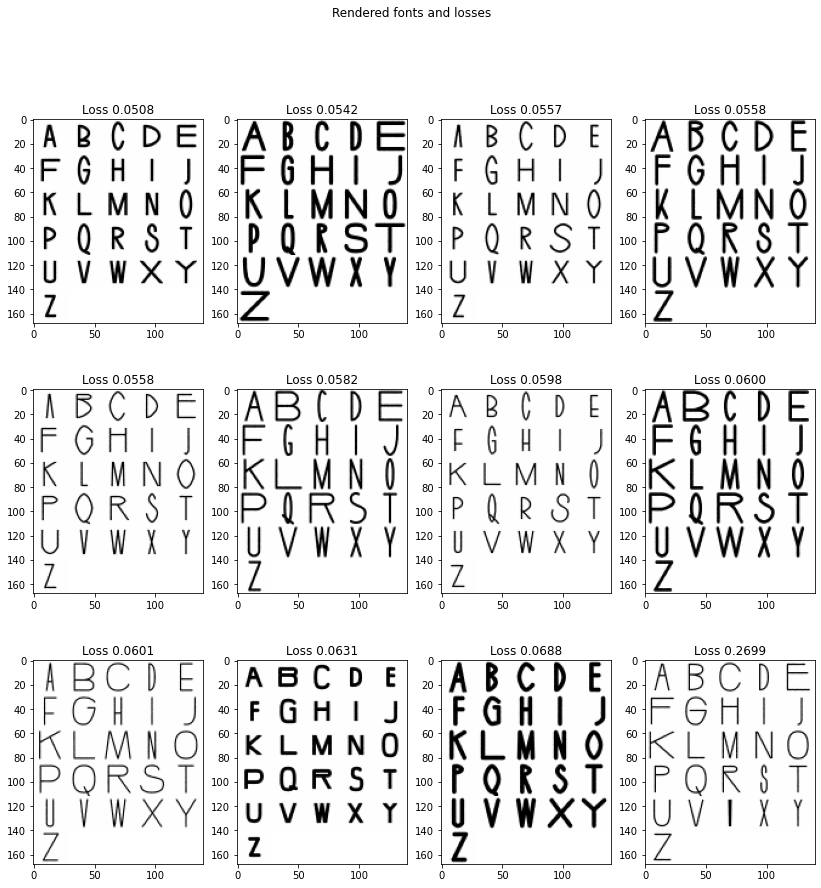

In [6]:
losses = sorted([x["final_loss"] for x in res_exp1])
_ = show_variation_renders(res_exp1)

## 2. Interlude: Comparing Loss Spread

Let's compare the loss spreads between the previous OCR model and the current, augmented one.

In [7]:
def _do_count_losses(param_dict,
    version = None,
    iters = 50,
    msg = ""
    ) -> dict:
    """Get loss statistics for learner, i.e. OCR `version`."""                
    learner = get_learner(version=version)
    learner.load_param_dict(param_dict)
    l = learner.get_current_loss(iters=iters, reduction=None)
    return print_losses(l, msg=f"Losses for version '{version}' {msg}")

def _compare_losses(
    res_exp1,
    non_aug_fp = "results/test_9_whole_alphabet/selected_variations_wo_div_adam.pkl"
    ) -> None:
    sel_vars_df = load(non_aug_fp)
    params = sel_vars_df.iloc[0].final_params
    losses_nonaug = _do_count_losses(params, None)
    losses_aug    = _do_count_losses(params, "aug")
    params = sorted(res_exp1, key=lambda x: x["final_loss"])[0]["final_params"]
    msg = "optimised with aug OCR"
    losses_nonaug_aug = _do_count_losses(params, None,  msg=msg)
    losses_aug_aug    = _do_count_losses(params, "aug", msg=msg)

Surprisingly, the loss spreads are not much different for the OCR models. The loss minima, however, obviously lie at different locations.

    Losses for version 'None' : Mean: 0.0490 • SD: 0.0004 (0.8%) • Spread 0.0015 (3.1%)
    Losses for version 'aug' : Mean: 0.0769 • SD: 0.0006 (0.7%) • Spread 0.0028 (3.7%)
    Losses for version 'None' optimised with aug OCR: Mean: 0.0746 • SD: 0.0006 (0.8%) • Spread 0.0022 (3.0%)
    Losses for version 'aug' optimised with aug OCR: Mean: 0.0513 • SD: 0.0003 (0.6%) • Spread 0.0013 (2.6%)

## 3. DEPR! Optimise Using Augmented OCR and Augmented Renderings

> This was run with a bug that prevented the augmentation having any effect on the renderings. We shan't rerun this experiment, however, because the `fancy_fit_2` optimisation is not well suited for noisy losses.

Extend the augmentations to the rendered fonts as well.

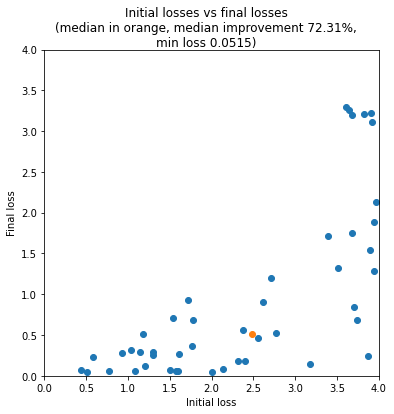

In [8]:
fn_exp2  = "variations_exp2_aug_ocr_aug_loss"
res_exp2 = create_or_load_variations(fn_exp2,
                                     lr = 1e-1,
                                     lr_factor = .9,
                                     iters = 40,
                                     ocr_version = "aug",
                                     use_ocr_tfms = True)

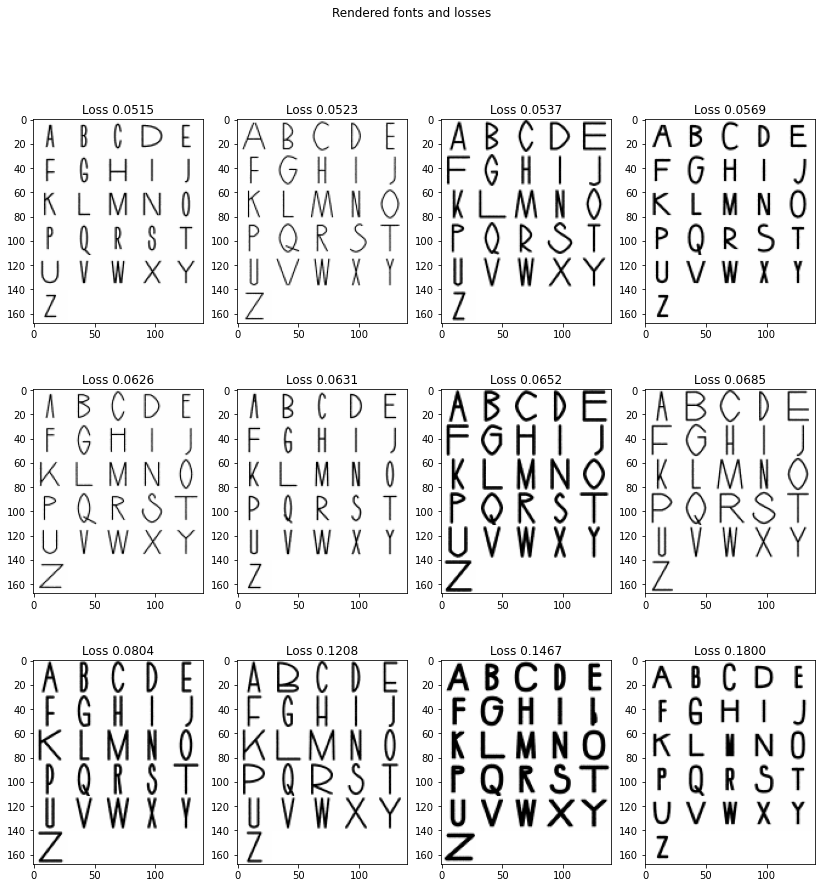

In [9]:
losses = sorted([x["final_loss"] for x in res_exp2])
_ = show_variation_renders(res_exp2)

## 4. DEPR! Optimise Using Augmented OCR and Augmented Renderings, P=1. and Larger BS

> This was run with a bug that prevented the augmentation having any effect on the renderings. We shan't rerun this experiment, however, because the `fancy_fit_2` optimisation is not well suited for noisy losses.

Extend the augmentations to the rendered fonts as well.

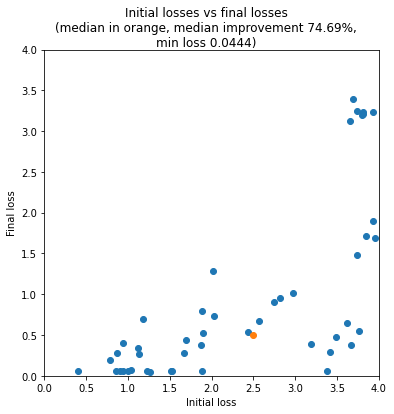

In [10]:
fn_exp3  = "variations_exp3_aug_ocr_aug_loss_p_1_big_bs"
res_exp3 = create_or_load_variations(fn_exp3,
                                     lr = 1e-1,
                                     lr_factor = .9,
                                     iters = 40,
                                     ocr_version = "aug",
                                     use_ocr_tfms = True,
                                     tfms_p = 1.,
                                     bs = 4 * len(VOCAB_UC)
                                     )

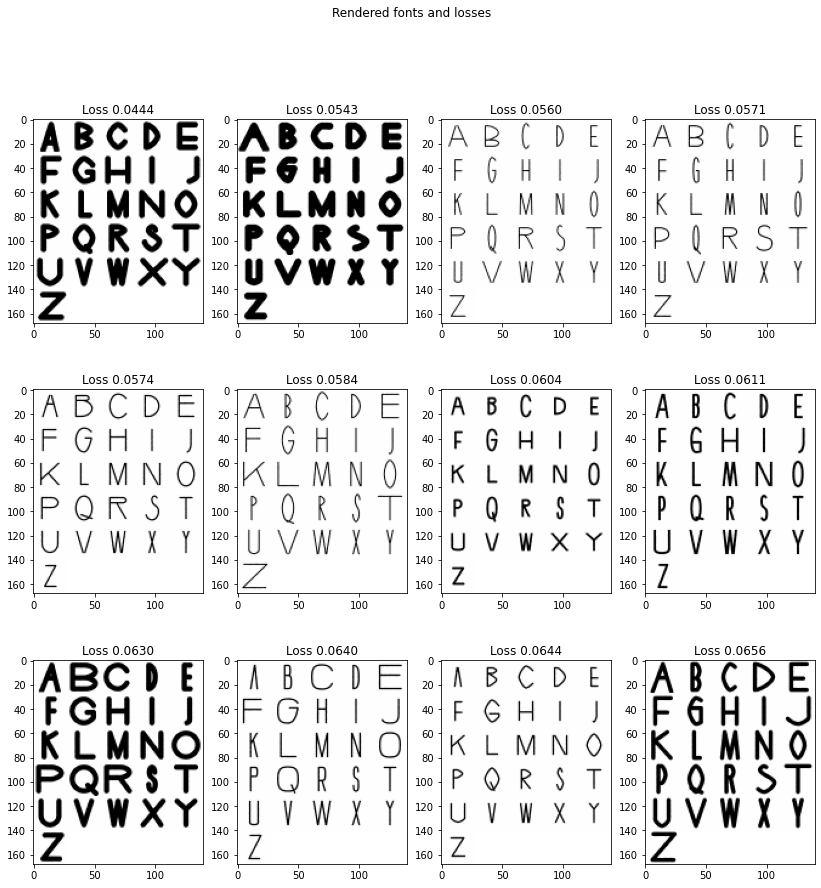

In [11]:
losses = sorted([x["final_loss"] for x in res_exp3])
_ = show_variation_renders(res_exp3)

## 5. Optimise Using Augmented OCR and Strongly Impaired Renderings

With the bug troubling the previous experiments fixed, we'll try optimising the alphabet with:

* a larger `bs`
* strong OCR transformations (blur)
* transformations applied always (p=1.)

/Users/kallejarvenpaa/opt/miniconda3/envs/ai-font-p3.9/lib/python3.9/site-packages/fastai/learner.py:55: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")
/Users/kallejarvenpaa/Desktop/AI-fontti/aifont/aifont/fontlearner.py:2408: UserWarning: Using default input_shape: (28, 28)
  warn(f"Using default input_shape: {input_shape}")
/Users/kallejarvenpaa/Desktop/AI-fontti/aifont/aifont/fontlearner.py:613: UserWarning: Are you sure you want to define bs when using from_vocab?
  if x in kwargs and kwargs[x] is not None: warn(f"Are you sure you want to define {x} when using from_vocab?")


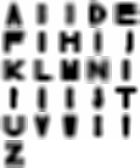

In [12]:
learner_args = dict(version = "aug", 
                    use_ocr_tfms = True,
                    tfms_p = 1.,
                    tfms_set = "strong",
                    bs = 4 * len(VOCAB_UC))
learner = get_learner(seed = 42, **learner_args)
# apply_best_params(learner, res_exp3)
learner.render_letters(apply_tfms=True)

[0.05643501505255699, 0.06174403429031372, 0.07270172238349915, 0.07616174966096878, 0.133610799908638, 0.19451607763767242, 0.28352251648902893, 0.28554534912109375, 0.2921517491340637, 0.4131511151790619, 0.4140731394290924, 0.45616886019706726, 0.6040125489234924, 0.6410780549049377, 0.6827977895736694, 0.7209910750389099, 1.1891733407974243, 2.933112621307373]


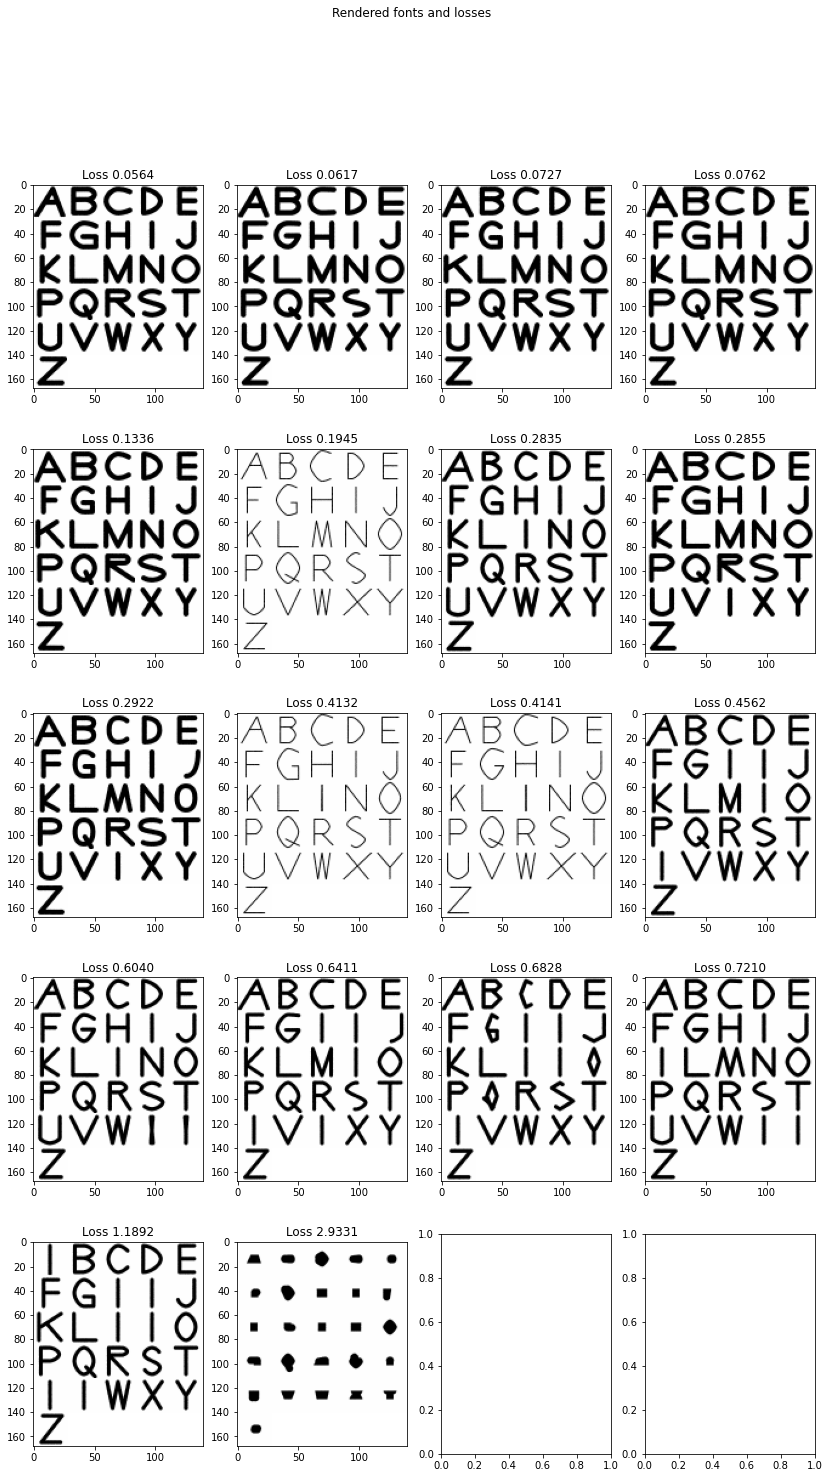

In [13]:
fn_exp4a = "variations_exp4_aug_ocr_aug_loss_p_1_big_bs_nonoise"
# res_exp4a = fancy_fit_3_variations(fn_exp4a, **learner_args)
fn_exp4b = "variations_exp4_aug_ocr_aug_loss_p_1_big_bs_nonoise_b"
# res_exp5 = fancy_fit_3_variations(fn_exp4b, **learner_args)
fn_exp4 = os.path.join(DUMP_FOLDER, "variations_exp4_augocr_augloss_p1_bs4_nonoise")
# res_exp4 = []
# for i in range(5):  res_exp4.append(load(f"{DUMP_FOLDER}/{fn_exp4a}{i}.pkl"))
# for i in range(13): res_exp4.append(load(f"{DUMP_FOLDER}/{fn_exp4b}{i}.pkl"))
# dump(res_exp4, fn_exp4)
res_exp4 = load(fn_exp4)
losses = sorted([x["final_loss"] for x in res_exp4])
print(losses)
_ = show_variation_renders(res_exp4, n=None)

**Now, these are interesting results!** We can see much clearer convergence in the results compared to the previous experiments where the renderings where not impaired.

What we also see is that the results with the worst losses (`> .2`) all have one or more letters that have collapsed mostly due to too small a width parameter. We should be able to remedy that by specifying a minimum width or running a more explorative search for local parameters after global optimisation.

For a nicer analysis, let's look at the results next to the blurred bersions.

/Users/kallejarvenpaa/opt/miniconda3/envs/ai-font-p3.9/lib/python3.9/site-packages/fastai/learner.py:55: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")
/Users/kallejarvenpaa/Desktop/AI-fontti/aifont/aifont/fontlearner.py:2408: UserWarning: Using default input_shape: (28, 28)
  warn(f"Using default input_shape: {input_shape}")
/Users/kallejarvenpaa/Desktop/AI-fontti/aifont/aifont/fontlearner.py:613: UserWarning: Are you sure you want to define bs when using from_vocab?
  if x in kwargs and kwargs[x] is not None: warn(f"Are you sure you want to define {x} when using from_vocab?")


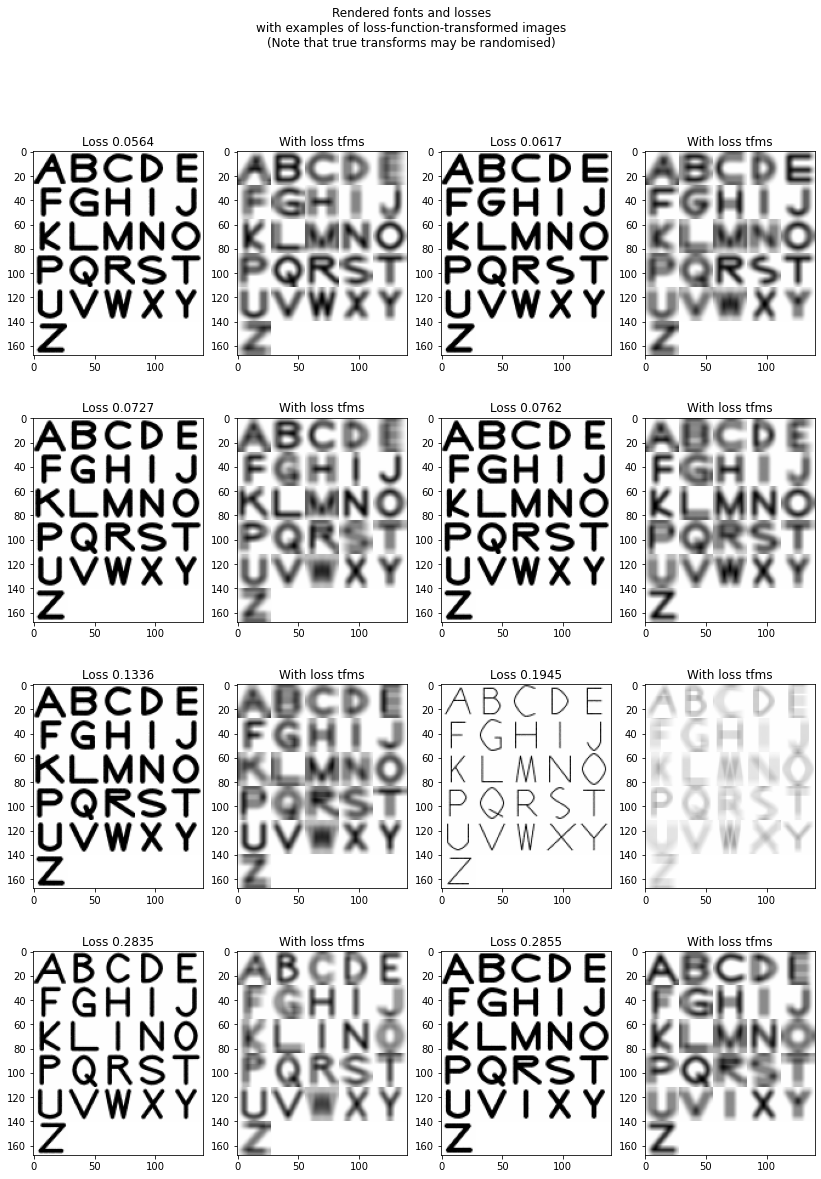

In [14]:
learner = get_learner(**learner_args)
_ = show_variation_renders(res_exp4, n=8, incl_tfms=True, learner=learner)

## 6. Optimise With an Even Stronger Blur

Same as the previous experiment, but making the blur even sronger.

/Users/kallejarvenpaa/opt/miniconda3/envs/ai-font-p3.9/lib/python3.9/site-packages/fastai/learner.py:55: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")
/Users/kallejarvenpaa/Desktop/AI-fontti/aifont/aifont/fontlearner.py:2408: UserWarning: Using default input_shape: (28, 28)
  warn(f"Using default input_shape: {input_shape}")
/Users/kallejarvenpaa/Desktop/AI-fontti/aifont/aifont/fontlearner.py:613: UserWarning: Are you sure you want to define bs when using from_vocab?
  if x in kwargs and kwargs[x] is not None: warn(f"Are you sure you want to define {x} when using from_vocab?")


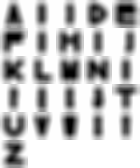

In [15]:
learner_args = dict(version = "aug", 
                    use_ocr_tfms = True,
                    tfms_p = 1.,
                    tfms_set = "xstrong",
                    bs = 4 * len(VOCAB_UC))
learner = get_learner(seed = 42, **learner_args)
learner.render_letters(apply_tfms=True)

In [16]:
fn_exp5 = "variations_exp5_xstrong_aug"
fp_exp5 = os.path.join(DUMP_FOLDER, fn_exp5)
# fancy_fit_3_variations(fn_exp5, zero_width=True, **learner_args)
# res_exp5 = []
# for i in range(14): res_exp5.append(load(f"{DUMP_FOLDER}/{fn_exp5}{i}.pkl"))
# dump(res_exp5, fp_exp5)
res_exp5 = load(fp_exp5)
losses = sorted([x["final_loss"] for x in res_exp5])
print(losses)

[0.15736675262451172, 0.16198955476284027, 0.45117756724357605, 0.526073694229126, 0.528425931930542, 0.6575729846954346, 0.7204868793487549, 0.8687669038772583, 0.9192405939102173, 0.9331983327865601, 1.0019657611846924, 1.1202738285064697, 3.0318641662597656, 3.1243398189544678]


The results look delightfully convergent with the ones from the previous experiment.

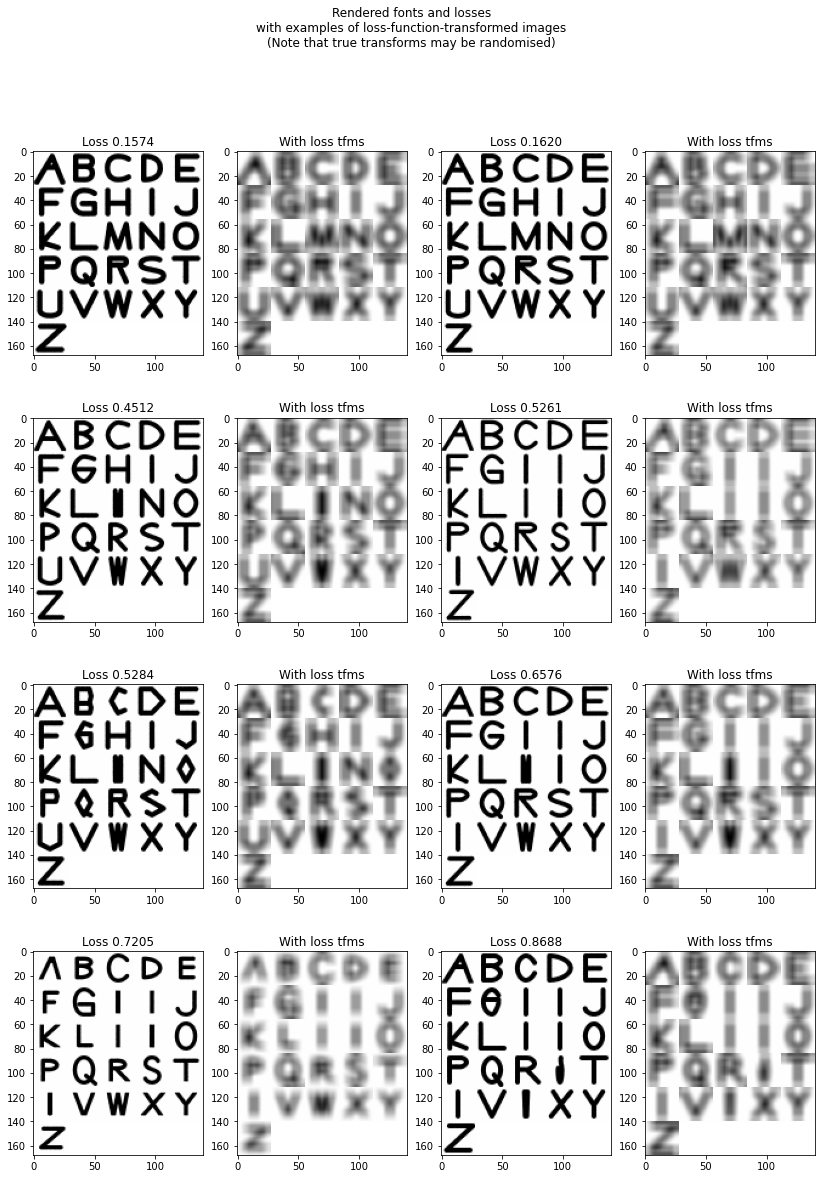

In [28]:
_ = show_variation_renders(res_exp5, n=8, incl_tfms=True, learner=learner)

## 7. Fine-Tuning Using `fit_letters`

Attempting to fine-tune the best results from the previous experiment by fine tuning individual letters and letter groups.

/Users/kallejarvenpaa/opt/miniconda3/envs/ai-font-p3.9/lib/python3.9/site-packages/fastai/learner.py:55: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")
/Users/kallejarvenpaa/Desktop/AI-fontti/aifont/aifont/fontlearner.py:2423: UserWarning: Using default input_shape: (28, 28)
  warn(f"Using default input_shape: {input_shape}")
/Users/kallejarvenpaa/Desktop/AI-fontti/aifont/aifont/fontlearner.py:613: UserWarning: Are you sure you want to define bs when using from_vocab?
  if x in kwargs and kwargs[x] is not None: warn(f"Are you sure you want to define {x} when using from_vocab?")


Init loss: 0.15727215856313706


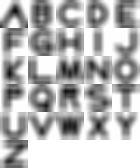

In [5]:
def get_learner_for_fit_letters() -> Tuple[float, VectorLearner]:
    "Shortcut for getting a learner for tests in this experiment."
    gc.collect()
    learner_args = dict(version = "aug", 
                        use_ocr_tfms = True,
                        tfms_p = 1.,
                        tfms_set = "xstrong",
                        bs = 4 * len(VOCAB_UC))
    learner = get_learner(seed = 42, **learner_args)
    fn_exp5 = "variations_exp5_xstrong_aug"
    fp_exp5 = os.path.join(DUMP_FOLDER, fn_exp5)
    res_exp5 = load(fp_exp5)
    # losses = sorted([x["final_loss"] for x in res_exp5])
    apply_best_params(learner, res_exp5)
    init_loss = learner.get_current_loss(iters=10)
    print(f"Init loss: {init_loss}")
    return init_loss, learner

init_loss, learner = get_learner_for_fit_letters()
learner.render_letters(apply_tfms=True)

In [41]:
groups = learner.get_param_groups()
group_letters = list(groups.keys())
print(group_letters)

['', 'CGJOQS', 'AMNVW', 'CGOQ', 'AXZ', 'BPR', 'CGS', 'HNU', 'AV', 'EF', 'TZ', 'XY', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'J', 'K', 'L', 'M', 'P', 'Q', 'R', 'S', 'U', 'W', 'X', 'Y', 'Z']


In [42]:
def fit_all_letter_groups(learner):
    losses_after_fitting = OrderedDict()
    for l in group_letters:
        if l == '': continue
        print(f"Optimising group '{l}'")
        with learner.no_progress(): learner.fit_letters(l, n_epoch=30, lr=1e-2)
        new_loss = learner.get_current_loss(iters=10)
        losses_after_fitting[l] = new_loss
        print(f"Represenative loss {new_loss}")
    return losses_after_fitting

# losses_after_fitting = fit_all_letter_groups(learner)

Optimising group 'CGJOQS'


/Users/kallejarvenpaa/opt/miniconda3/envs/ai-font-p3.9/lib/python3.9/site-packages/fastai/callback/core.py:51: UserWarning: You are shadowing an attribute (logger) that exists in the learner. Use `self.learn.logger` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


Represenative loss 0.1570793628692627
Optimising group 'AMNVW'
Represenative loss 0.15711767822504044
Optimising group 'CGOQ'
Represenative loss 0.15711667835712434
Optimising group 'AXZ'
Represenative loss 0.15700868517160416
Optimising group 'BPR'
Represenative loss 0.15706838071346282
Optimising group 'CGS'
Represenative loss 0.1571779355406761
Optimising group 'HNU'
Represenative loss 0.15699422657489776
Optimising group 'AV'
Represenative loss 0.15726809948682785
Optimising group 'EF'
Represenative loss 0.15732247084379197
Optimising group 'TZ'
Represenative loss 0.1572698637843132
Optimising group 'XY'
Represenative loss 0.15726660043001175
Optimising group 'A'
Represenative loss 0.1572813421487808
Optimising group 'B'
Represenative loss 0.15734914392232896
Optimising group 'C'
Represenative loss 0.1596137523651123
Optimising group 'D'
Represenative loss 0.1598254382610321
Optimising group 'E'
Represenative loss 0.15983850806951522
Optimising group 'F'
Represenative loss 0.159929

    Represenative loss 0.1570793628692627
    Optimising group 'AMNVW'
    Represenative loss 0.15711767822504044
    Optimising group 'CGOQ'
    Represenative loss 0.15711667835712434
    Optimising group 'AXZ'
    Represenative loss 0.15700868517160416
    Optimising group 'BPR'
    Represenative loss 0.15706838071346282
    Optimising group 'CGS'
    Represenative loss 0.1571779355406761
    Optimising group 'HNU'
    Represenative loss 0.15699422657489776
    Optimising group 'AV'
    Represenative loss 0.15726809948682785
    Optimising group 'EF'
    Represenative loss 0.15732247084379197
    Optimising group 'TZ'
    Represenative loss 0.1572698637843132
    Optimising group 'XY'
    Represenative loss 0.15726660043001175
    Optimising group 'A'
    Represenative loss 0.1572813421487808
    Optimising group 'B'
    Represenative loss 0.15734914392232896
    Optimising group 'C'
    Represenative loss 0.1596137523651123
    Optimising group 'D'
    Represenative loss 0.1598254382610321
    Optimising group 'E'
    Represenative loss 0.15983850806951522
    Optimising group 'F'
    Represenative loss 0.1599293977022171
    Optimising group 'G'
    Represenative loss 0.15710328817367553
    Optimising group 'J'
    Represenative loss 0.15727080553770065
    Optimising group 'K'
    Represenative loss 0.1571734681725502
    Optimising group 'L'
    Represenative loss 0.15718216598033904
    Optimising group 'M'
    Represenative loss 0.15735779851675033
    Optimising group 'P'
    Represenative loss 0.1576698362827301
    Optimising group 'Q'
    Represenative loss 0.15799473524093627
    Optimising group 'R'
    Represenative loss 0.15778704434633256
    Optimising group 'S'
    Represenative loss 0.15805167257785796
    Optimising group 'U'
    Represenative loss 0.1578131303191185
    Optimising group 'W'
    Represenative loss 0.15783984810113907
    Optimising group 'X'
    Represenative loss 0.15810317546129227
    Optimising group 'Y'
    Represenative loss 0.15794142186641694
    Optimising group 'Z'
    Represenative loss 0.15792948603630066

> It seems obvious that merely limiting the optimised letters yields no further improvement.

Next, we'll try to rerandomise each letter group's parameters and optimise them.

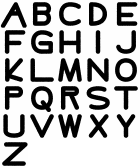

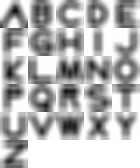

In [6]:
display(learner.render_letters())
display(learner.render_letters(apply_tfms=True))

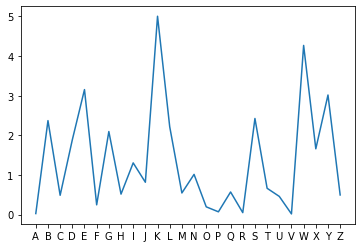

In [7]:
i_losses = plot_current_individual_losses(learner)

In [8]:
def set_target_letters(self,
    letters: Iterable[str] = None
    ) -> Callable:
    """Prepare to fit only the specific parameters affecting `letters` or all if `None`."""
    orig_letters = self.dls.train.letters
    if letters not in (None, ""):
        self.freeze_params()
        params = [o for o in self.param_names if param_affects(o, letters, incl_general=False)]
        if len(params) == 0:
            warn(f"No applicable params found for letters '{letters}'.")
            return
        self.unfreeze_params(params)
        self.dls.train.letters = letters
    def _reset(): self.dls.train.letters = orig_letters
    return _reset

def fit_letters_with_rand_init(
    learner,
    iters = 20,
    epochs = 20,
    lr = 1e-1,
    fn = "fit_letters_test"
    ) -> dict:
    """Try to fit all letter groups again with random initialization."""
    init_params = learner.get_param_dict()
    all_res = {}
    dump_fn = os.path.join(DUMP_FOLDER, fn)
    for letters in group_letters:
        if letters == '': continue
        report(f"Optimising group '{letters}'")
        _reset = set_target_letters(learner, letters)
        params = [o for o in learner.params if o.requires_grad]
        # print(f"Unfrozen params: {len(params)}")
        self = learner
        res = []
        for i in range(iters):
            self.load_param_dict(init_params)
            for p in params: self.set_param(p, -4. + random.random() * 8.)
            with self.no_progress(): self.fit(epochs, lr=lr)
            l = self.get_current_loss(iters=10)
            report(f"Fitted {i + 1}/{iters} • Loss: {l:.4f}")
            res.append(dict(loss=l, params=self.get_param_dict()))
        best_loss = min([x["loss"] for x in res])
        print(f"Best loss for {letters}: {best_loss:.4f}")
        all_res[letters] = res
        dump(all_res, dump_fn)

# all_res = fit_letters_with_rand_init(learner)

> It looks like there might be improvements for individual letter groups. Let's have a further look at the results now.

In [7]:
def apply_fit_letter_results(fn = "fit_letters_test",
    loss_iters = 10
    ) -> None:
    """Apply the results from `fit_letters_with_rand_init`."""
    init_loss, learner = get_learner_for_fit_letters()
    dump_fn = os.path.join(DUMP_FOLDER, fn)
    all_res = load(dump_fn)
    last_loss = learner.get_current_loss(loss_iters)
    last_params = learner.get_param_dict()
    for letters, res in all_res.items():
        rel_params = learner.get_effective_params(letters)
        best_res = sorted(res, key=lambda x: x["loss"])[0]
        for p in rel_params: learner.set_param(p, best_res["params"][p])
        test_loss = learner.get_current_loss(loss_iters)
        loss_d = last_loss - test_loss
        print(f"Letters '{letters}' • Loss delta: {loss_d:.4f}")
        if loss_d > 0.: 
            last_loss = test_loss
            last_params = learner.get_param_dict()
        else: learner.load_param_dict(last_params)
    print(f"Final loss: {last_loss} ({init_loss})")

# apply_fit_letter_results()

Letters 'CGJOQS' • Loss delta: -0.0676
Letters 'AMNVW' • Loss delta: -0.1110
Letters 'CGOQ' • Loss delta: -0.0047
Letters 'AXZ' • Loss delta: -0.0138
Letters 'BPR' • Loss delta: -0.0719
Letters 'CGS' • Loss delta: -0.0032
Letters 'HNU' • Loss delta: -0.0149
Letters 'AV' • Loss delta: 0.0009
Letters 'EF' • Loss delta: -0.0099
Letters 'TZ' • Loss delta: 0.0022
Letters 'XY' • Loss delta: -0.0027
Letters 'A' • Loss delta: -0.0027
Letters 'B' • Loss delta: -0.0036
Letters 'C' • Loss delta: -0.0005
Letters 'D' • Loss delta: -0.0001
Letters 'E' • Loss delta: -0.0008
Letters 'F' • Loss delta: -0.0081
Letters 'G' • Loss delta: -0.1105
Letters 'J' • Loss delta: -0.0007
Letters 'K' • Loss delta: -0.0022
Letters 'L' • Loss delta: -0.0001
Letters 'M' • Loss delta: -0.0008
Letters 'P' • Loss delta: -0.0186
Letters 'Q' • Loss delta: -0.0400
Letters 'R' • Loss delta: -0.0484
Letters 'S' • Loss delta: -0.1201
Letters 'U' • Loss delta: -0.0022
Letters 'W' • Loss delta: 0.0001
Letters 'X' • Loss delta: -

> It seems that we can't eke out any substantial improvements with this method either. We should treat this as a welcome finding as it means the general optimisation procedure is good enough in finding a global optimum.

    Letters 'CGJOQS' • Loss delta: -0.0676
    Letters 'AMNVW' • Loss delta: -0.1110
    Letters 'CGOQ' • Loss delta: -0.0047
    Letters 'AXZ' • Loss delta: -0.0138
    Letters 'BPR' • Loss delta: -0.0719
    Letters 'CGS' • Loss delta: -0.0032
    Letters 'HNU' • Loss delta: -0.0149
    Letters 'AV' • Loss delta: 0.0009
    Letters 'EF' • Loss delta: -0.0099
    Letters 'TZ' • Loss delta: 0.0022
    Letters 'XY' • Loss delta: -0.0027
    Letters 'A' • Loss delta: -0.0027
    Letters 'B' • Loss delta: -0.0036
    Letters 'C' • Loss delta: -0.0005
    Letters 'D' • Loss delta: -0.0001
    Letters 'E' • Loss delta: -0.0008
    Letters 'F' • Loss delta: -0.0081
    Letters 'G' • Loss delta: -0.1105
    Letters 'J' • Loss delta: -0.0007
    Letters 'K' • Loss delta: -0.0022
    Letters 'L' • Loss delta: -0.0001
    Letters 'M' • Loss delta: -0.0008
    Letters 'P' • Loss delta: -0.0186
    Letters 'Q' • Loss delta: -0.0400
    Letters 'R' • Loss delta: -0.0484
    Letters 'S' • Loss delta: -0.1201
    Letters 'U' • Loss delta: -0.0022
    Letters 'W' • Loss delta: 0.0001
    Letters 'X' • Loss delta: -0.0166
    Letters 'Y' • Loss delta: -0.0105
    Letters 'Z' • Loss delta: -0.0012
    Final loss: 0.15411390215158463 (0.15709228813648224)

## Export

In [ ]:
#hide
from nbdev.export import notebook2script; notebook2script()

Converted 00_core.ipynb.
Converted 01_fontsampler.ipynb.
Converted 02_ocrlearner.ipynb.
Converted 03_fontlearner.ipynb.
Converted index.ipynb.
